In [318]:
#!pip install sqlalchemy

In [27]:
# Imported libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
import psycopg2

# Database

- https://www.postgresqltutorial.com/postgresql-python/connect/
- https://www.postgresqltutorial.com/postgresql-python/insert/

In [28]:
def insert_df(df,table):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # read connection parameters
        #params = config()

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(host="<database host>",
                                database="<database name>",
                                user="<database username>",
                                password="<username password>")

        # create a cursor
        cur = conn.cursor()
        
        # select the columns
        cols = ','.join(list(df.columns))        
        
        # separate the insert_values
        insert_values = [tuple(x) for x in df.to_numpy()]        
        
        # create the query
        sql = "INSERT INTO "+table+"("+cols+") VALUES" +str(insert_values)[1:-1]        
        
        # execute a statement
        print('Inserting values...')
        cur.execute(sql,vars=None)        

        # commit the changes to the database
        conn.commit()
       
        # close communication with the database
        cur.close()
        return conn
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')

# URI Arguments

Fitbit OAuth 2.0 Tutorial - https://dev.fitbit.com/build/reference/web-api/troubleshooting-guide/oauth2-tutorial/

In [29]:
# Auth token
token = '<insert your token here>'

#Header
headers={'Authorization':'Bearer ' + token}

# Sleep

Get Sleep Log List - https://dev.fitbit.com/build/reference/web-api/sleep/get-sleep-log-list/

In [30]:
# get today's date
today = str(date.today())

In [31]:
# create the final dataframe
sleep_df = pd.DataFrame()

# GET steps url
url = 'https://api.fitbit.com/1.2/user/-/sleep/list.json?beforeDate='+today+'&sort=desc&offset=0&limit=100'

# request the url
sleep_r = requests.get(url,headers=headers)


if sleep_r.ok:
    # create the dataframe with only the necessary columns
    sleep_r = sleep_r.json()
    sleep_df = pd.json_normalize(sleep_r['sleep'])[['dateOfSleep', 'startTime', 'endTime', 'duration', 'efficiency',
                                                    'isMainSleep', 'minutesAfterWakeup','minutesAsleep', 'minutesAwake', 
                                                    'minutesToFallAsleep','timeInBed','levels.summary.deep.minutes',
                                                    'levels.summary.light.minutes','levels.summary.rem.minutes']]
    
    # iterate through the pages
    while sleep_r['pagination']['next']:     
        
        
        # request the new url
        sleep_r = requests.get(sleep_r['pagination']['next'],headers=headers).json()

        # create a new datafram with the necessary columns
        sleep_df_temp = pd.json_normalize(sleep_r['sleep'])[['dateOfSleep', 'startTime', 'endTime', 'duration', 'efficiency','isMainSleep', 
                                                             'minutesAfterWakeup','minutesAsleep', 'minutesAwake', 
                                                             'minutesToFallAsleep','timeInBed','levels.summary.deep.minutes',
                                                             'levels.summary.light.minutes','levels.summary.rem.minutes']]
        # concatenate the two dataframes
        sleep_df = pd.concat([sleep_df,sleep_df_temp],axis=0,ignore_index=True)
        

        # destroy the temp dataframe
        del sleep_df_temp  
else: print(f'Error processing request. {sleep_r.status_code} - {sleep_r.reason}')    

In [32]:
# rename the dataframe columns to match the table columns
sleep_df = sleep_df.rename(columns={'dateOfSleep':'date_of_sleep', 'startTime':'start_time', 'endTime':'end_time',
       'isMainSleep':'is_main_sleep', 'minutesAfterWakeup':'minutes_after_wakeup', 'minutesAsleep':'minutes_asleep', 
                                    'minutesAwake':'minutes_awake','minutesToFallAsleep':'minutes_to_fall_asleep', 
                                    'timeInBed':'time_in_bed','levels.summary.deep.minutes':'deep_sleep',
                                    'levels.summary.light.minutes':'light_sleep','levels.summary.rem.minutes':'rem_sleep'})


In [33]:
# only consider main sleep rowsvvvvvvvvvvvvvv
sleep_df = sleep_df[sleep_df['is_main_sleep']==True]

In [34]:
# drop rows with null values
sleep_df = sleep_df.dropna(axis=0)

In [35]:
# convert duration to minutes (is in miliseconds)
sleep_df.loc[:,'duration'] = sleep_df['duration']/(1000*60)

## Detecting outliers
- Using https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

In [36]:
# check stats
sleep_df['duration'].describe()

count    687.000000
mean     437.697234
std       73.934975
min      180.000000
25%      395.000000
50%      444.000000
75%      482.500000
max      675.000000
Name: duration, dtype: float64

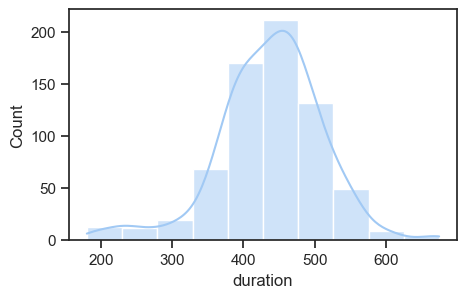

In [38]:
# set the style
sns.set(style='ticks',palette="pastel")

# plot the distribtion of duration
plt.figure(figsize=(5,3),dpi=100)
sns.histplot(sleep_df['duration'],bins=10,kde=True);

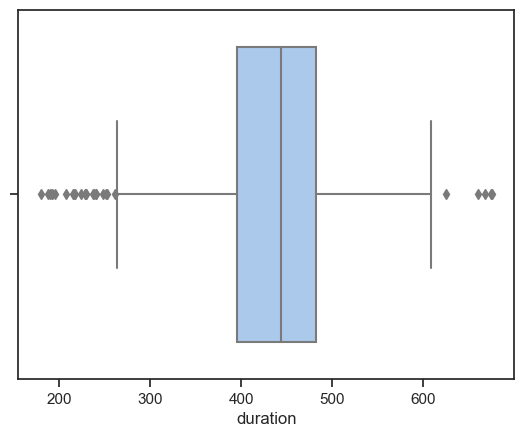

In [39]:
# boxplot
sns.boxplot(x=sleep_df['duration']);

In [40]:
# Using IQR
q75,q25 = np.percentile(sleep_df['duration'],[75,25])
iqr = q75 - q25
lower_limit = q25 - 1.5*iqr
upper_limit = q75 + 1.5*iqr
print(f'Lower limit: {lower_limit}')
print(f'Upper limit: {upper_limit}')

Lower limit: 263.75
Upper limit: 613.75


In [41]:
# select the index
drop_index = sleep_df[(sleep_df['duration']<lower_limit)|(sleep_df['duration']>upper_limit)].index

# drop the outliers
sleep_df = sleep_df.drop(drop_index,axis=0)

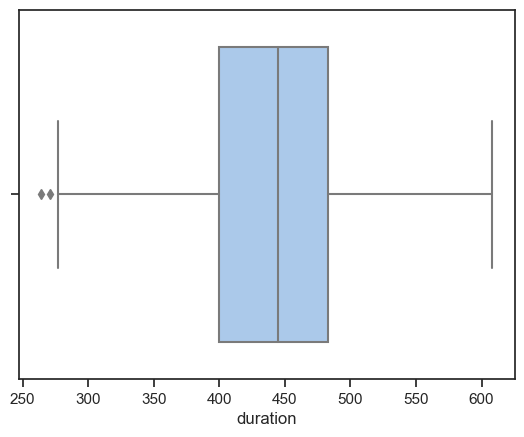

In [43]:
# boxplot
sns.boxplot(x=sleep_df['duration']);

In [949]:
# insert the dataframe into the table
insert_df(sleep_df,'sleeps')

Connecting to the PostgreSQL database...
Inserting values...
Database connection closed.


<connection object at 0x000002670B75ABF0; dsn: 'user=postgres password=xxx dbname=fitbit_api host=localhost', closed: 1>

# Heart Rate
- Get your heart rate https://dev.fitbit.com/build/reference/web-api/heartrate-timeseries/
- Get Heart Rate Time Series by Date Range https://dev.fitbit.com/build/reference/web-api/heartrate-timeseries/get-heartrate-timeseries-by-date-range/



In [447]:
# create a datelist with the dates in the sleep_df
datelist = pd.to_datetime(sleep_df['date_of_sleep'])
#datelist[datelist<='2022-10-08']

The API accepts for the enddate a maximun of 100 days

- https://renanmf.com/subtracting-years-from-a-date-in-python/

In [183]:
# initial date
initial_date = today

# empty dataframe
hr_df = pd.DataFrame()

# get information for the past 3 years
for year in range(1,4):    
    
    # get the previous date
    previous_date = str(date.today() - relativedelta(years=year))    
    
    # url with the date ranges
    url = 'https://api.fitbit.com/1/user/-/activities/heart/date/'+previous_date+'/'+initial_date+'.json'        
        
    # request the url
    hr_r = requests.get(url,headers=headers)
    
    # check if the request went through
    if hr_r.ok:
        hr_df2 = pd.json_normalize(hr_r.json()['activities-heart']) # create the dataframe
        if len(hr_df)>0:
            hr_df = pd.concat([hr_df,hr_df2],axis=0)
        else: hr_df = hr_df2.copy()
    else: print(f'Error processing request. {hr_r.status_code} - {hr_r.reason}')
    
    # set the new initial date
    initial_date = str(date.today() - relativedelta(days=1,years=year))    

In [562]:
# select the necessary columns
hr_df = hr_df[['dateTime','value.restingHeartRate']]
# rename the column to match the table in the databse
hr_df = hr_df.rename(columns={'dateTime':'date_time','value.restingHeartRate':'resting_heart_rate'})

In [564]:
# fill null values of restig_heart_rate with 0
hr_df['resting_heart_rate'] = hr_df['resting_heart_rate'].fillna(0)

In [565]:
# insert the df into the database
insert_df(hr_df,'heart_rates')

Connecting to the PostgreSQL database...
Inserting values...
Database connection closed.


<connection object at 0x0000026704F277B0; dsn: 'user=postgres password=xxx dbname=fitbit_api host=localhost', closed: 1>

# Steps

- Get Activity Time Series by Date - https://dev.fitbit.com/build/reference/web-api/activity-timeseries/get-activity-timeseries-by-date/
- Get Activity Time Series by Date Range - https://dev.fitbit.com/build/reference/web-api/activity-timeseries/get-activity-timeseries-by-date-range/

In [185]:
# initial date
initial_date = today

# define the final dataset
steps_df = pd.DataFrame()

# get data for the last 3 years
for year in range(1,4):
    
    # previous year
    previous_date = str(date.today() - relativedelta(years=year))    
    
    # build the url
    url = 'https://api.fitbit.com/1/user/-/activities/steps/date/'+previous_date+'/'+initial_date+'.json'    
    
    # request the url
    steps_request = requests.get(url,headers=headers)
    
    # check if the request went through
    if steps_request.ok:
        
        # create the temporary dataframe
        steps_df_temp = pd.json_normalize(steps_request.json()['activities-steps'])
        
        if len(steps_df)>0:
            # concatenate the two dataframes
            steps_df = pd.concat([steps_df,steps_df_temp],axis=0)
        else:
            # copy the temp datafram into the final
            steps_df = steps_df_temp.copy()
        
        # clean temp dataframe
        del steps_df_temp        
        
    else:
        # problems with the request
        print(f'Error processing request. {steps_request.status_code} - {steps_request.reason}')
    
    # set the new initial date
    initial_date = str(date.today() - relativedelta(days=1,years=year)) 
    

In [615]:
# rename the columns to match the table in the database
steps_df = steps_df.rename(columns={'dateTime':'date_time','value':'steps'})

1096

In [617]:
# insert the dataframe into the database
insert_df(steps_df,'steps')

Connecting to the PostgreSQL database...
Inserting values...
Database connection closed.


<connection object at 0x0000026704F27E10; dsn: 'user=postgres password=xxx dbname=fitbit_api host=localhost', closed: 1>

# Activities

Get Daily Activity Summary - https://dev.fitbit.com/build/reference/web-api/activity/get-daily-activity-summary/

In [191]:
# define final dataframe
activities_df = pd.DataFrame() #detail activities
summary_df = pd.DataFrame() # summary


# iterate through the datelist
# dates processed
# (datelist>='2022-09-01')&(datelist<'2023-01-01')
# (datelist>='2022-06-17')&(datelist<'2022-09-01')
# (datelist>='2022-03-01')&(datelist<'2022-06-17')
# (datelist>='2022-01-01')&(datelist<'2022-03-01')
# (datelist>='2021-09-01')&(datelist<'2022-01-01')
# (datelist>='2021-06-01')&(datelist<'2021-09-01')
# (datelist>='2021-03-01')&(datelist<'2021-06-01')
# (datelist>='2021-01-01')&(datelist<'2021-03-01')

for date_df in datelist[(datelist>='2020-09-01')&(datelist<'2020-09-30')]:
    
    # set the url    
    url = 'https://api.fitbit.com/1/user/-/activities/date/'+date_df.strftime("%Y-%m-%d")+'.json'    
    
    # request the url
    activities_r = requests.get(url,headers=headers)
    
    # check if the request went through
    if activities_r.ok:        
        '''
        # create the summary dataframe
        summary_df_temp = pd.json_normalize(activities_r.json()['summary'])
        summary_df = pd.concat([summary_df,summary_df_temp],axis=0,ignore_index=True)
        
        del summary_df_temp
        '''
        # check if the day has activiies
        if activities_r.json()['activities']:
            # create the temporary detail activities dataframe
            activities_df_temp = pd.json_normalize(activities_r.json()['activities'])[['startDate','name','startTime','steps',
                                                                            'duration','calories']]
            # create the temporary summary dataframe
            summary_df_temp = pd.json_normalize(summary_r.json()['summary'])
            
            # add the columns date of activity 
            summary_df_temp.insert(0,'date_activity',date_df.strftime("%Y-%m-%d"))

            # check if the final dataframe has elements
            if len(activities_df)>0:

                # concatenate the final and temp dataframes
                activities_df = pd.concat([activities_df,activities_df_temp],axis=0,ignore_index=True)
                summary_df = pd.concat([summary_df,summary_df_temp],axis=0,ignore_index=True)
            else:

                # final dataset is empty
                activities_df = activities_df_temp.copy()
                summary_df = summary_df_temp.copy()
                
            # destroy the temp dataframes
            del activities_df_temp
            del summary_df_temp
    else:
        # problems with the request
        print(f'Error processing request. {activities_r.status_code} - {activities_r.reason}')
        print(url)
        break

In [194]:
# rename the columns to match the table
activities_df = activities_df.rename(columns={'startDate':'start_date', 'startTime':'start_time'})
summary_df = summary_df.rename(columns={'activityCalories':'activity_calories', 'caloriesBMR':'calories_bmr', 
'caloriesOut':'calories_out','marginalCalories':'marginal_calories','restingHeartRate':'resting_heart_rate',
'sedentaryMinutes':'sedentary_minutes', 'fairlyActiveMinutes':'fairly_Active_minutes',
                                        'lightlyActiveMinutes':'lightly_active_minutes', 
                                        'veryActiveMinutes':'very_active_minutes','activeScore':'active_score'})

In [195]:
# drop unnecessary columns
summary_df = summary_df.drop(columns=['distances','heartRateZones'])

In [782]:
# insert the dataframe into the detail activities table
insert_df(activities_df,'activities')

Connecting to the PostgreSQL database...
Inserting values...
Database connection closed.


<connection object at 0x0000026707D5F8C0; dsn: 'user=postgres password=xxx dbname=fitbit_api host=localhost', closed: 1>

In [ ]:
# insert the dataframe into the summary activities table
insert_df(summary_df,'activities_summary')